# Exercise 5
- Required packages:
    - `Plots.jl` (for plotting)
    - `ExcelReaders.jl` (to read excel file)

In [1]:
using Plots
pyplot()
using ExcelReaders

## Functions for HP filter
- First, we'll use the loop method.
- Second, we'll use a sparse matrix and via the function `spdiagm` to create matrix `H`.

In [2]:
abstract type MatrixType end
struct Dense <: MatrixType end
struct Sparse <: MatrixType end
abstract type AssignMethod end
struct Loop <: AssignMethod end
struct Vectorized <: AssignMethod end

### Loop version

In [3]:
function create_matrix(λ, N::Integer, ::Dense, ::Loop)
    H = zeros(N, N)
    assign!(H, λ, N)
    return H
end
function create_matrix(λ, N::Integer, ::Sparse, ::Loop)
    H = spzeros(N, N)
    assign!(H, λ, N)
    return H
end
function assign!(H::AbstractMatrix, λ, N) 
    for j = 1:N
        for i = 1:N
            if j == 1
                H[1, 1] = 1+λ;
                H[2, 1] = -2λ;
                H[3, 1] = λ;
            elseif j == 2
                H[1, 2] = -2λ;
                H[2, 2] = 1 + 5λ;
                H[3, 2] = -4λ;
                H[4, 2] = λ;
            elseif j == N - 1
                H[N - 3, N - 1] = λ;
                H[N - 2, N - 1] = -4λ;
                H[N - 1, N - 1] = 1 + 5λ;
                H[N,     N - 1] = -2λ;
            elseif j == N
                H[N - 2, N] = λ;
                H[N - 1, N] = -2λ;
                H[N,     N] = 1+λ;
            else
                H[j - 2, j] = λ;
                H[j - 1, j] = -4λ;
                H[j,     j] = 1 + 6λ;
                H[j + 1, j] = -4λ;
                H[j + 2, j] = λ;
            end
        end
    end
end

assign! (generic function with 1 method)

### Vectorized version

In [4]:
function create_matrix(λ::Real, N::Integer, ::Sparse, ::Vectorized) 
    return spdiagm(-2 => fill(λ, N-2),
                    -1 => vcat(-2λ, fill(-4λ, N - 3), -2λ),
                     0 => vcat(1 + λ, 1 + 5λ, fill(1 + 6λ, N-4),
                               1 + 5λ, 1 + λ),
                     1 => vcat(-2λ, fill(-4λ, N - 3), -2λ),
                     2 => fill(λ, N-2))
end
function create_matrix(λ::Real, N::Integer, ::Dense, ::Vectorized)
    H = zeros(N, N)
    H += diagm(fill(λ, N-2), -2)
    H += diagm(vcat(-2λ, fill(-4λ, N - 3), -2λ), -1)
    H += diagm(vcat(1 + λ, 1 + 5λ, fill(1 + 6λ, N-4),
                           1 + 5λ, 1 + λ), 0)
    H += diagm(vcat(-2λ, fill(-4λ, N - 3), -2λ), 1)
    H += diagm(fill(λ, N-2), 2)
    return H
end

create_matrix (generic function with 4 methods)

In [5]:
function hp_filter(y::AbstractVector{T}, λ::Real, mt::MatrixType, am::AssignMethod) where T <: Real
    N = length(y)
    H = create_matrix(T(λ), N, mt, am)
    y_trend = H \ y
    y_cyclical = y - y_trend
    return y_trend, y_cyclical
end;

## Apply HP filter

NOTE: First run for each include compilation time, so don't take it seriously.

In [6]:
data = readxlsheet("data/US_Data.xlsx", "Data");
y = collect(data[4:end, 2]); # removing header
T = length(y);

# Looped dense version
println("Looped dense")
@time (ytr1600, yc1600) = hp_filter(Float64.(y), 1600, Dense(), Loop());
@time (ytr1e5, yc1e5)   = hp_filter(Float64.(y), 1e5, Dense(), Loop());

# Looped sparse version
println("Looped sparse")
@time (ytr1600, yc1600) = hp_filter(Float64.(y), 1600, Sparse(), Loop());
@time (ytr1e5, yc1e5)   = hp_filter(Float64.(y), 1e5, Sparse(), Loop());

# Dense matrix version
println("Vectorized dense")
@time (ytr1600, yc1600) = hp_filter(Float64.(y), 1600, Dense(), Vectorized());
@time (ytr1e5, yc1e5)   = hp_filter(Float64.(y), 1e5, Dense(), Vectorized());

# Sparse matrix version
println("Vectorized sparse")
@time (ytr1600, yc1600) = hp_filter(Float64.(y), 1600, Sparse(), Vectorized());
@time (ytr1e5, yc1e5)   = hp_filter(Float64.(y), 1e5, Sparse(), Vectorized());

Looped dense
  2.542403 seconds (1.33 M allocations: 70.537 MiB, 1.11% gc time)
  0.023778 seconds (998 allocations: 954.137 KiB)
Looped sparse
  1.268429 seconds (250.85 k allocations: 13.654 MiB)
  0.017410 seconds (1.21 k allocations: 255.492 KiB)
Vectorized dense
  0.652097 seconds (284.03 k allocations: 20.536 MiB, 1.96% gc time)
  0.018391 seconds (1.24 k allocations: 5.349 MiB, 50.37% gc time)
Vectorized sparse
  1.745333 seconds (1.13 M allocations: 62.273 MiB, 1.25% gc time)
  0.006968 seconds (1.39 k allocations: 284.764 KiB)


## With large data

In [7]:
N_test = 5_000
y_test = randn(N_test)
# Looped dense version
println("Looped dense")
@time (ytrtest_del, yctest_del) = hp_filter(y_test, 1600, Dense(), Loop());

# Looped sparse version
println("Looped sparse")
@time (ytrtest_spl, yctest_spl) = hp_filter(y_test, 1600, Sparse(), Loop());

# Dense matrix version
println("Vectorized dense")
@time (ytrtest_dev, yctest_dev) = hp_filter(y_test, 1600, Dense(), Vectorized());

# # Sparse matrix version
println("Vectorized sparse")
@time (ytrtest_spv, yctest_spv) = hp_filter(y_test, 1600, Sparse(), Vectorized());

Looped dense
  2.370069 seconds (23 allocations: 381.585 MiB, 7.99% gc time)
Looped sparse
  1.976020 seconds (104 allocations: 4.094 MiB)
Vectorized dense
  3.920070 seconds (310 allocations: 2.236 GiB, 18.76% gc time)
Vectorized sparse
  0.005138 seconds (383 allocations: 4.475 MiB)


## Plot trend component


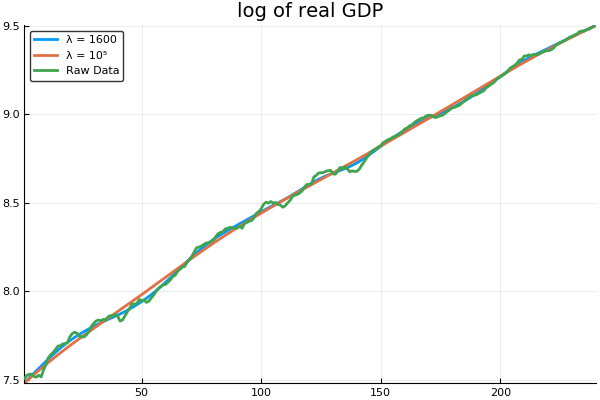

In [8]:
plot([log.(ytr1600), log.(ytr1e5), log.(y)], lw = 2,
     lab = ["λ = 1600" "λ = 10⁵" "Raw Data"],
     title = "log of real GDP")

## Plot cyclical component


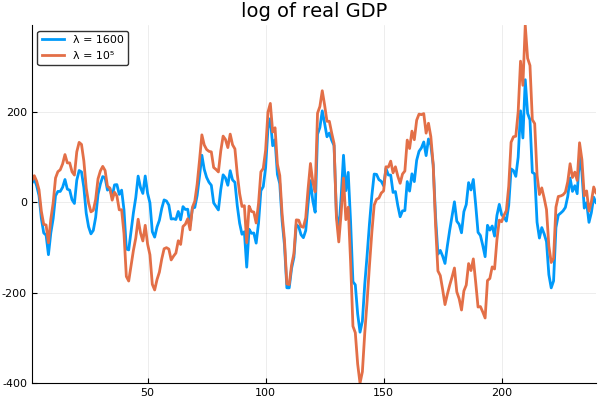

In [9]:
p = plot([yc1600, yc1e5], lw = 2,
         lab = ["λ = 1600" "λ = 10⁵" "Raw Data"],
         title = "log of real GDP")